
## STOCHASTIC MODELING
MODULE 5 | LESSON 3


---

# **POLICY ITERATION**

|  |  |
|:---|:---|
|**Reading Time** |  1h |
|**Prior Knowledge** |Markov process, Optimization, Monte Carlo  |
|**Keywords** |Dynamic programming, value function


---

*In this notebook, we introduce an alternative way to analyze the optimal course of action for the agent in a dynamic programming problem exploiting the methodology of policy iteration. Make sure you understand this properly because it is going to lay the foundation for the next lesson.*

## **1. Policy Iteration**

An alternative way to analyze the optimal course of action for the agent in a DP problem is to exploit the methodology of policy iteration. This strategy features two nested loops. The inner loop fixes a policy $\pi(s)$ and finds the corresponding value function attached to that policy $v_\pi$. The outer loop iterates over policies using the value-maximization update, which yields a "greedy" action with respect to the current value function. This method also guarantees convergence to the optimal choices. The algorithm can be described as follows:

Begin with some flat guess, say $v^{(0)}(s)=0$, for all $s$, and an arbitrary policy $\pi^{(0)}(s)$.
* Policy evaluation step:
  1. Compute $v^{(1)}(s) = \sum_{s'}\mathbb{P}\big(s'|s,\pi^{(0)}(s)\big)\bigg[  r\big(s,\pi^{(0)}(s)\big) +  \gamma\ v^{(0)}(s')\bigg]$.
  2. Stop if $v^{(0)}$ and $v^{(1)}$ are close enough. Otherwise, set $v^{(0)}=v^{(1)}$ and return to step 1.
* Policy improvement step:
  1. Compute $\pi^{(1)}(s) = \arg\underset{a}{\max}\sum_{s'}\mathbb{P}\big(s'|s,a\big)\bigg[  r\big(s,a\big) +  \gamma\ v^{(1)}(s')\bigg]$.
  2. Stop if $\pi^{(0)}$ and $\pi^{(1)}$ are close enough. Otherwise, set $v^{(0)}=v^{(1)}$,  $\pi^{(0)}=\pi^{(1)}$, and return to the Policy evaluation step.

The policy iteration algorithm divides value iteration into two steps. In the latter, each evaluation of $v(s)$ involved an implicit choice of new policy through the $\max$ function. In the policy iteration method, the policy remains fixed until finding the optimal value and then applying separately the $\max$ function. While in practical terms, the differences are subtle between value and policy iteration, the separation of policy evaluation and improvement may lead to faster convergence. 

## **2. The Gridworld**

The figure below displays a $4\times4$ grid. The problem for the agent is to follow directions from each cell to reach the terminal state by ending up in any of the shaded cells. We can set up the state-space as $\mathcal{S}=\{0,1,2...,14\}$ where 0 denotes the terminal state. Cells 0 and 15 generate the same reward, so there is no need to formally define them separately. Notwithstanding, in our code below, we are going to explicitly differentiate between them. 

The agent can take four actions, $\mathcal{A}=\{up,down,right,left\}$. The reward in each transition is -1 until the terminal state is reached. Thus, the problem for the agent is to find the minimum distance from any cell to either of the shaded cells.

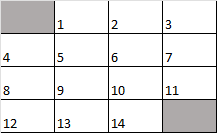

We are going to describe step by step the solution to the gridworld problem with policy iteration. However, the first challenging task in this problem is to determine the transitions across states. Because the agent has full control of the directions to follow, the transitions are deterministic given each choice. The block of code below creates a matrix that determines, for each position and action, which is the destination cell. For ease of coding, it is now useful to create two different states for states 0 and 15. Notice that the code is general enough to admit different sizes of the gridworld, $N$, as long as it is square. 

In [1]:
# Import libraries to use in this notebook
import matplotlib.pyplot as plt
import numpy as np

# SOLVING THE GRIDWORLD EXAMPLE.
# Setting up the model parameters and transitions

N = 16
GRID_WIDTH = np.sqrt(N)
S_GRID = np.linspace(1, N - 2, N - 2)
A = 4  # number of actions

# Build an array that indicates, for each state, the destination cells
# from moving up, down, right, or left
destinations = np.zeros((N, A), dtype=np.int8)
destinations[N - 1, :] = (N - 1) * np.ones((A), dtype=np.int8)  # noQA E203
for ss in range(1, N - 1):  # noQA E203
    # determine row of position ss in the grid
    row_ss = np.floor(ss / GRID_WIDTH) + 1

    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (
        ss - GRID_WIDTH < 0
    )
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (
        ss + GRID_WIDTH > N - 1
    )
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (
        ss >= row_ss * GRID_WIDTH - 1
    )
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (
        ss <= (row_ss - 1) * GRID_WIDTH
    )  # noQA E203

print(destinations)

[[ 0  0  0  0]
 [ 1  5  2  0]
 [ 2  6  3  1]
 [ 3  7  3  2]
 [ 0  8  5  4]
 [ 1  9  6  4]
 [ 2 10  7  5]
 [ 3 11  7  6]
 [ 4 12  9  8]
 [ 5 13 10  8]
 [ 6 14 11  9]
 [ 7 15 11 10]
 [ 8 12 13 12]
 [ 9 13 14 12]
 [10 14 15 13]
 [15 15 15 15]]


In the block of code below, we posit a random policy that sets the probability of going in each direction equal to 0.25. Then, we iteratively compute the value at each cell of following that policy. The maximum values are attached to cells 1, 4, 11, and 14. On the other hand, this random policy generates the lowest values in cells 3 and 12. Can you guess why this is the case?

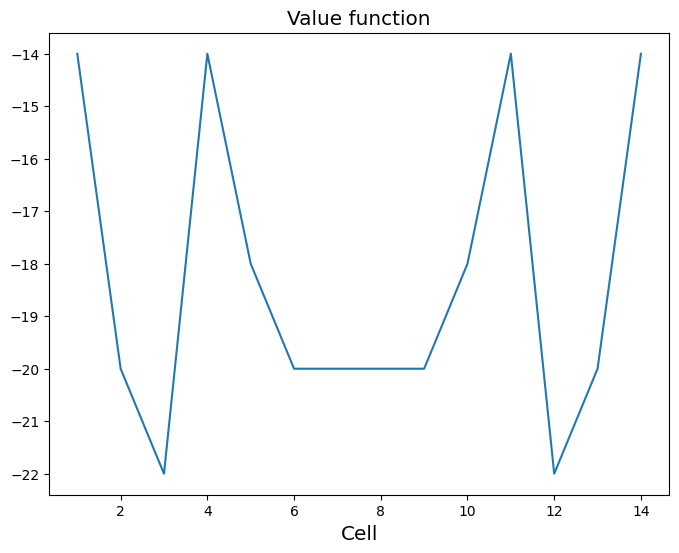

In [2]:
# SOLVING THE GRIDWORLD EXAMPLE. Policy evaluation step

# Define policy evaluation function


def policy_evaluation(policy, tol, iten):
    """
    Return the value function given a policy choice
    """
    nstates, nactions = policy.shape[0], policy.shape[1]
    value = np.zeros((nstates))
    for ite in range(1, iten):
        value_old = value.copy()
        value = np.zeros((nstates))
        for ss in range(1, nstates - 1):
            value[ss] = np.dot(
                policy[ss, :], -np.ones(nactions) + value_old[destinations[ss, :]]
            )
        if np.max(np.absolute(np.subtract(value_old, value))) < tol:
            break

    return value, ite


# Assume an initial policy that is random
policy = np.ones((N, A)) / A
# Value iteration, given a policy
ITETOL = 1e-4
ITEMAX = 500

value, ite = policy_evaluation(policy, ITETOL, ITEMAX)

plt.plot(S_GRID, value[1 : N - 1])  # noQA E203
plt.title("Value function", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

From the value function estimated above, we can observe that, for instance, the value attached to cell 6 is -20. This means that the random policy takes in expectation 20 moves until reaching a terminal cell. Notice that for cells that are one step away from terminal cells, the value is -14, implying that it takes 14 steps to reach termination. Obviously, the random movement policy has some room for improvement. We do this next.

Next, we take the policy improvement step. We take the value function estimated above and check what is the best course of action for those values.

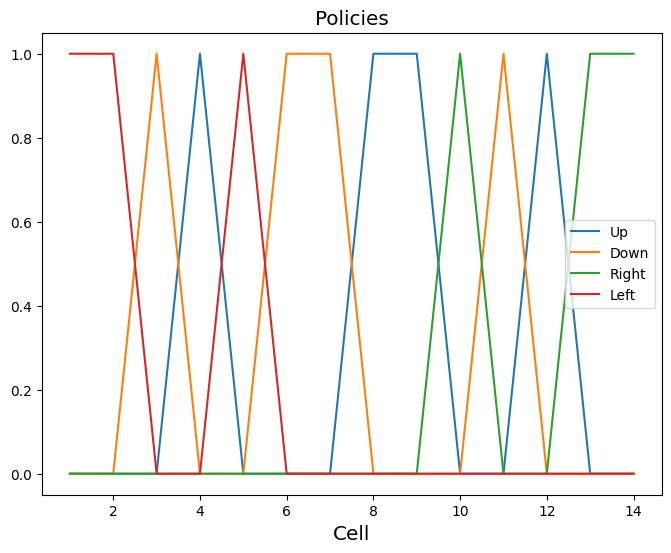

In [4]:
# SOLVING THE GRIDWORLD EXAMPLE. Policy improvement step


def policy_improvement(value, nactions):  # noQA E203
    """
    Return the improved policy given a value function
    """
    nstates = value.shape[0]
    policy = np.zeros((nstates, nactions))
    for ss in range(1, nstates - 1):  # noQA E203
        policy_opt = np.zeros((nactions))
        val0 = -np.inf
        for aa in range(0, nactions):
            val1 = -1 + value[destinations[ss, aa]]
            if val1 > val0:
                aa_opt = aa
                val0 = val1
        policy_opt[aa_opt] = 1.0
        policy[ss, :] = policy_opt  # noQA E203

    return policy


# Policy improvement, given a value
policy = policy_improvement(value, A)

plt.plot(S_GRID, policy[1 : N - 1, :])  # noQA E203
plt.title("Policies", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")
plt.legend(["Up", "Down", "Right", "Left"])

fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

The optimal policies quickly change after one policy improvement step. In the code above, we are imposing non-random actions. This means that, in case of ties, we put greater priority over some actions than over others. Specifically, we sequentially loop $\{up,down,right,left\}$ to find the candidate optimal policy with a strict improvement, which imposes some preference over actions that appear first in the ordering. 

With some additional coding, we can allow for random choices in case of ties, or we can simply opt for looping over all actions in a random order. Please take a look at the numpy function *numpy.where* and check how we can impose random actions when ties arise.

Below, we integrate the two layers of the policy iteration algorithm to find the optimal policies in the gridworld.<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [5]:
# SOLVING THE GRIDWORLD EXAMPLE. Full iteration

# Assume an initial policy that is random
policy = np.ones((N, A)) / A

ITEMAX = 1000
ITETOL = 1e-4

for ite0 in range(1, ITEMAX):  # noQA E203
    # Policy evaluation, given a policy
    value, ite = policy_evaluation(policy, ITETOL, ITEMAX)
    # Policy improvement, given a value
    policy_old = policy.copy()
    policy = policy_improvement(value, A)
    if np.max(np.absolute(np.subtract(policy_old, policy))) < ITETOL:
        break

    print(ite0, ite)

1 173
2 4


Now we can visualize the optimal outcomes.

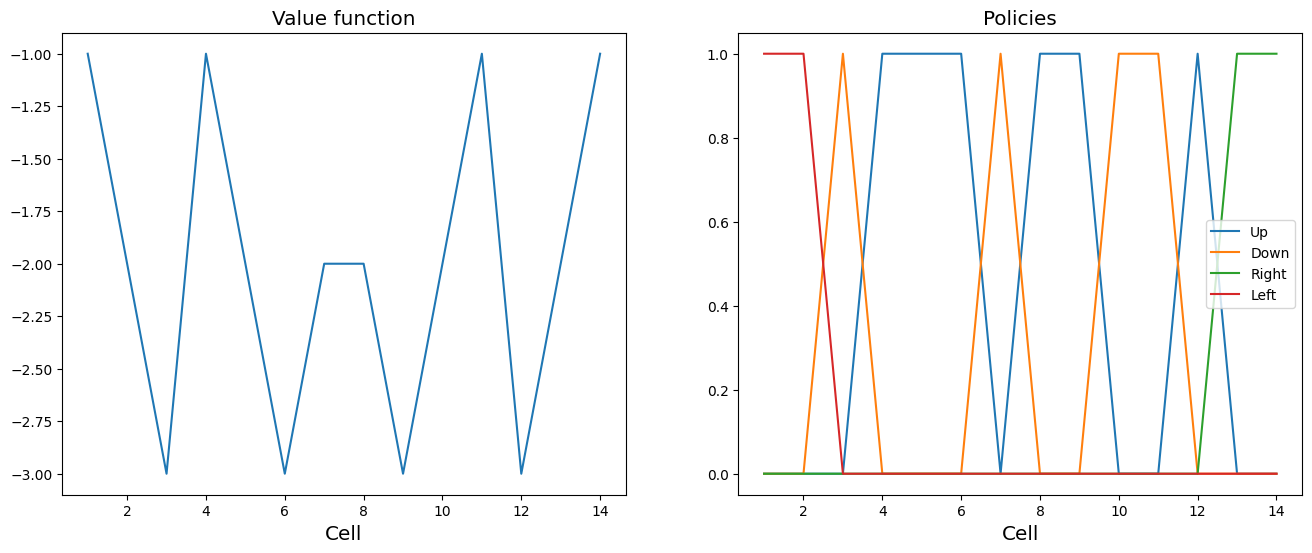

In [6]:
plt.subplot(1, 2, 1)
plt.plot(S_GRID, value[1 : N - 1])  # noQA E203
plt.title("Value function", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")

plt.subplot(1, 2, 2)
plt.plot(S_GRID, policy[1 : N - 1, :])  # noQA E203
plt.title("Policies", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")
plt.legend(["Up", "Down", "Right", "Left"])

fig = plt.gcf()
fig.set_size_inches(16, 6)
plt.show()

The algorithm just converges after two steps. Check now that the value attached to cells 1, 4, 11, and 14 is just -1 because the agent learns that those cells are just one step away from the terminal positions. In contrast, cells 3, 6, 9, and 12 are three steps away from the terminal cells, which makes them those with the lowest values.

Notice also that in some cells, the optimal policy is not unique. For instance, choosing either $up$ or $left$ when in cell $5$ leaves the agent one step from the goal so that their value is the same.

The policy iteration algorithm serves to illustrate the mechanisms that underlie the estimation of the optimal choices from the iteration on the value or $Q$-function. However, in terms of coding, the gridworld problem can be solved in much fewer lines of code using, for instance, $Q$ iteration.

5


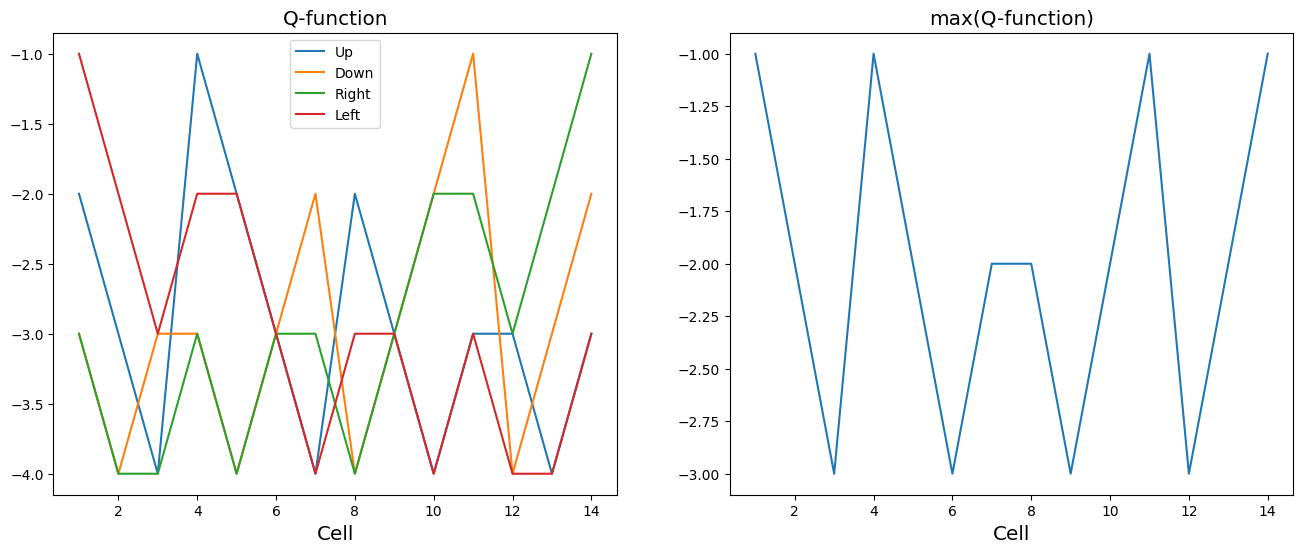

In [7]:
qvalue = np.zeros((N, A))

for ite in range(ITEMAX):  # noQA E203
    qvalue_old = qvalue.copy()
    qvalue = np.zeros((N, A))
    for aa in range(A):
        for ss in range(1, N - 1):  # noQA E203
            qvalue[ss, aa] = -1.0 + np.max(
                qvalue_old[destinations[ss, aa], :]
            )  # noQA E203
    if np.max(np.absolute(np.subtract(qvalue_old, qvalue))) < ITETOL:
        break
print(ite + 1)

qvalue_star = np.max(qvalue[1 : N - 1, :], axis=1)  # noQA E203

plt.subplot(1, 2, 1)
plt.plot(S_GRID, qvalue[1 : N - 1, :])  # noQA E203
plt.title("Q-function", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")
plt.legend(["Up", "Down", "Right", "Left"])
plt.subplot(1, 2, 2)
plt.plot(S_GRID, qvalue_star)
# plt.plot(S_GRID,value[:,0])
plt.title("max(Q-function)", fontsize="x-large")
plt.xlabel("Cell", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(16, 6)
plt.show()

## **3. Conclusion**

In this lesson, we have worked through the concept of policy iteration where the agent has full control of the transitions from one state to another. In the next lesson, we will easily adapt the algorithms to include some stochastic factors that influence the transitions.

See you there!

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
